In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_tree_leafs_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics
from tasks.boston_housing import make_task4 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names, name_b='C')

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
def get_predicted_rules(indices=None):
    indices = y_true if indices is None else indices
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    return pd.Series(pred_rule_nos, index=np.where(y_true)[0])

# Explanations

In [ ]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

This was run on a different machine (Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz):
- (0, 0)... 0:09:14.142372
- (0, 1)... 0:18:27.901131
- (0, 2)... 0:27:40.599932
- (1, 0)... 0:36:53.883956
- (1, 1)... 0:46:07.664046
- (1, 2)... 0:55:20.979274
- (2, 0)... 1:04:33.389025
- (2, 1)... 1:13:44.625557
- (2, 2)... 1:22:59.605905

## $(0,1)$

In [6]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [7]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

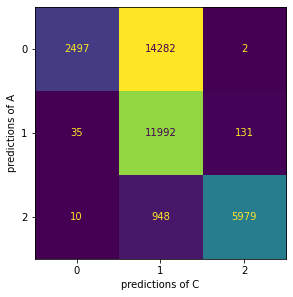

In [8]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-01.pdf')

In [9]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 1min 45s, sys: 1.59 s, total: 1min 46s
Wall time: 2min 8s


In [10]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

405

In [11]:
trees[-1].get_depth()

34

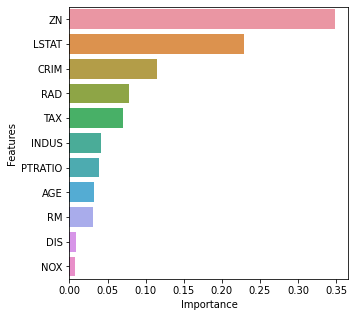

In [12]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

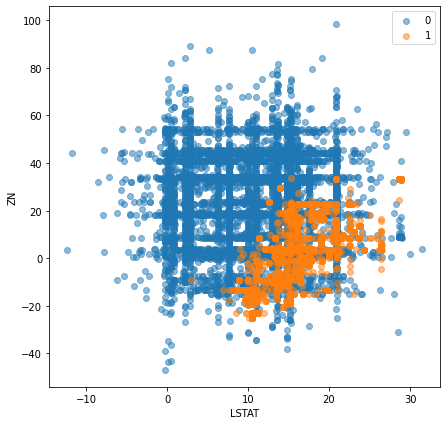

In [11]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [12]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07929222674267628, 1, 2)

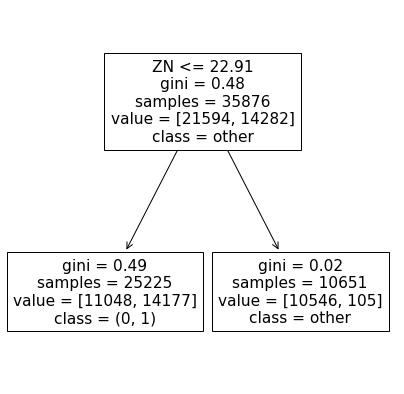

In [13]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [14]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 23 => (0, 1) [11048, 14177]


### 4 Leafs

In [15]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01952841542162531, 3, 4)

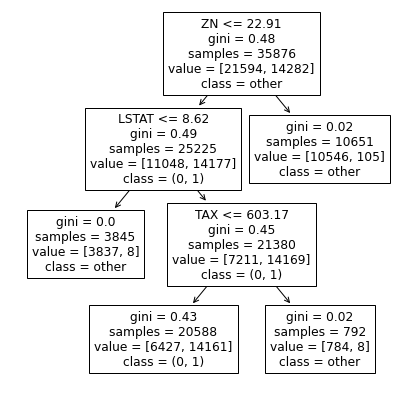

In [16]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [13]:
tree = [tree for tree in trees if tree.get_n_leaves() == 4][0]

In [14]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 23 and LSTAT > 8.62 and TAX <= 603 => (0, 1) [6427, 14161]


In [15]:
get_predicted_rules()

8      NaN
40     1.0
238    1.0
dtype: float64

In [17]:
indices = [8]
for level, tree in enumerate(trees[1:]):
    constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    if all([no != None for no in pred_rule_nos]):
        print(level)
        break

## $(1,0)$

In [43]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [44]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

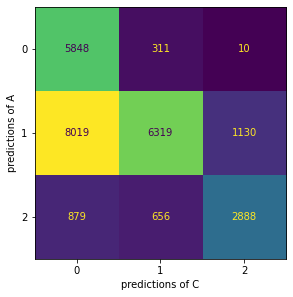

In [20]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-10.pdf')

In [21]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 58.7 s, sys: 1.02 s, total: 59.7 s
Wall time: 1min 16s


In [45]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

352

In [46]:
trees[-1].get_depth()

30

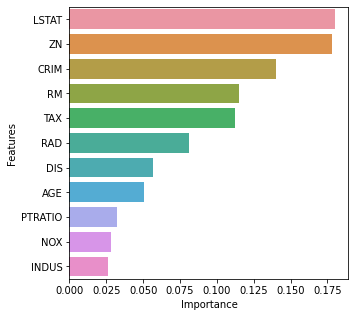

In [47]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

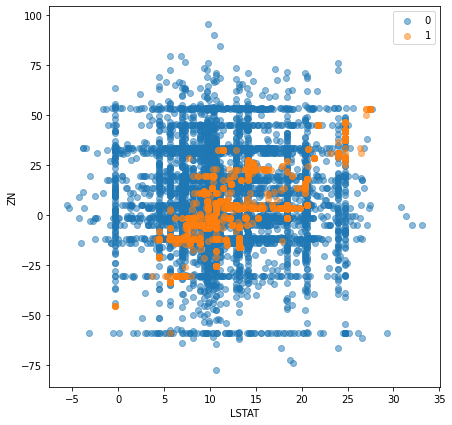

In [13]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [48]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02370747063194481, 1, 2)

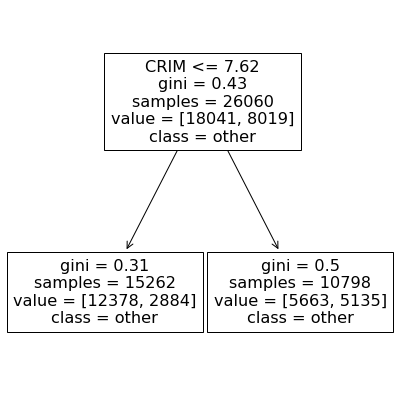

In [26]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [27]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

### 4 Leafs

In [49]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.021560687680527435, 3, 4)

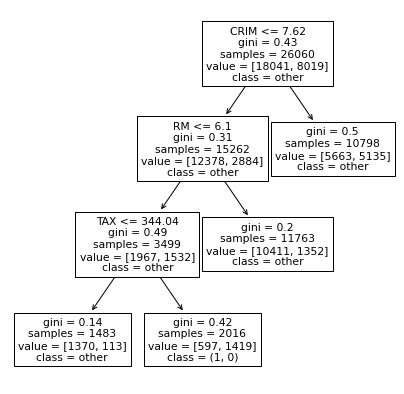

In [50]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [51]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]


In [52]:
get_predicted_rules()

23     None
156    None
dtype: object

In [30]:
indices = [23]
for level, tree in enumerate(trees):
    constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    if all([no != None for no in pred_rule_nos]):
        print(level)
        break

In [31]:
indices = [156]
for level, tree in enumerate(trees):
    constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    if all([no != None for no in pred_rule_nos]):
        print(level)
        break

## $(1,2)$

In [32]:
focus_class = '(1, 2)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [33]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

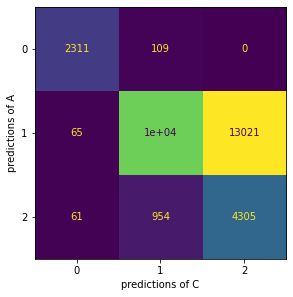

In [34]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-12.pdf')

In [35]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 1min 17s, sys: 1.14 s, total: 1min 18s
Wall time: 1min 33s


In [36]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

362

In [37]:
trees[-1].get_depth()

35

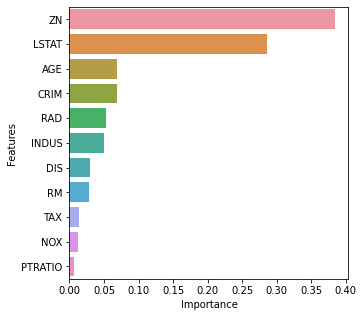

In [38]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

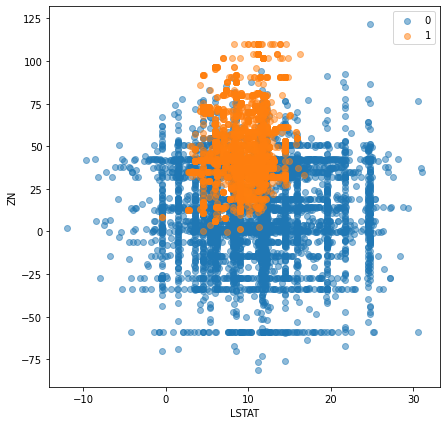

In [61]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [39]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07037882762220427, 1, 2)

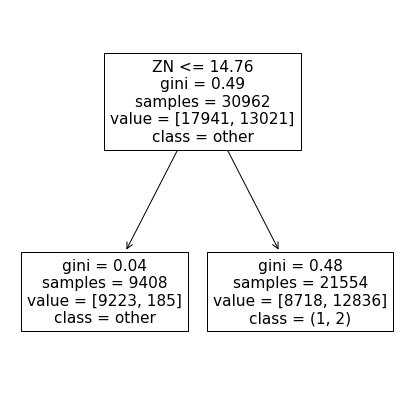

In [46]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [47]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 15 => (1, 2) [8718, 12836]


### 3 Leafs

In [40]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.03796445320005154, 2, 3)

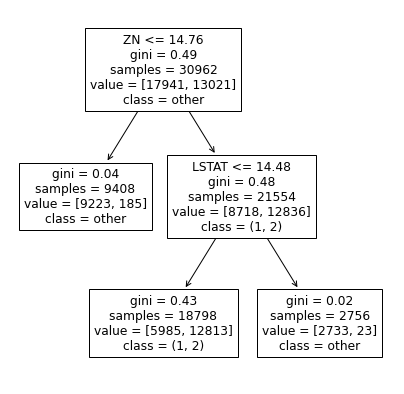

In [49]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [41]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 15 and LSTAT <= 14.48 => (1, 2) [5985, 12813]


In [42]:
get_predicted_rules()

22     1
55     1
68     1
122    1
206    1
dtype: int64

## $(2,1)$

In [53]:
focus_class = '(2, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [54]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

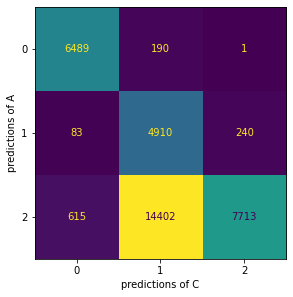

In [55]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-21.pdf')

In [56]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 2min 26s, sys: 2.61 s, total: 2min 28s
Wall time: 3min 22s


In [57]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

535

In [58]:
trees[-1].get_depth()

37

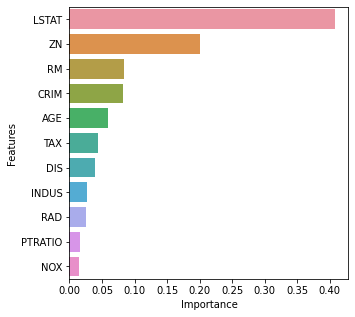

In [59]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

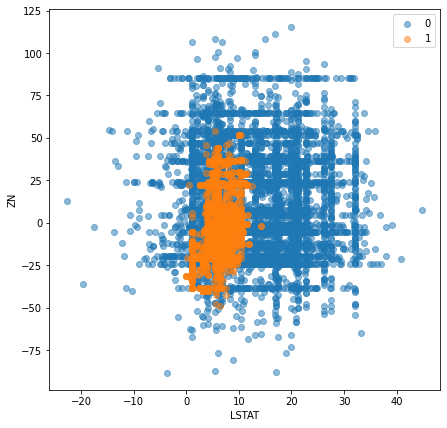

In [68]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [60]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07283219940974339, 1, 2)

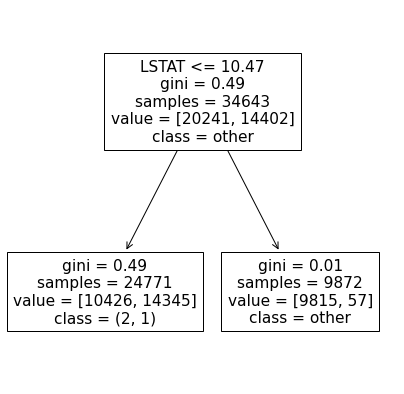

In [70]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [71]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. LSTAT <= 10.47 => (2, 1) [10426, 14345]


### 5 Leafs

In [61]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02132784731827797, 4, 5)

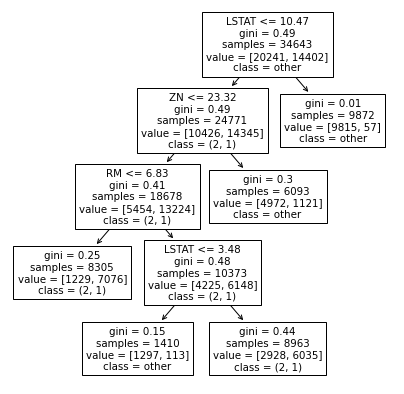

In [73]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [62]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 3.48 < LSTAT <= 10.47 and ZN <= 23 and RM > 6.83 => (2, 1) [2928, 6035]
2. LSTAT <= 10.47 and ZN <= 23 and RM <= 6.83 => (2, 1) [1229, 7076]


In [63]:
get_predicted_rules()

34     2
101    2
dtype: int64

# Additional Material

In [80]:
from diro2c_wrapper import get_surrogate_tree

In [81]:
feature_importances_per_class = {}
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    tree = get_surrogate_tree(explanation)
    feature_importances_per_class[label] = tree.feature_importances_

In [82]:
s = pd.concat([pd.Series(a, index=feature_names) for a in feature_importances_per_class.values()],
              keys=feature_importances_per_class.keys(), names=['Class', 'Feature'])
df = pd.DataFrame(s, columns=['Feature Importance']).reset_index()

In [83]:
s = df.groupby('Feature').mean()['Feature Importance']
order = s.sort_values(ascending=False).index

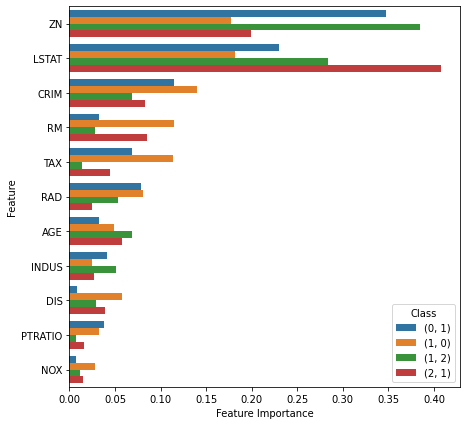

In [86]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(data=df, y='Feature', x='Feature Importance', hue='Class', order=order, ax=ax)
plt.savefig('figures/boston4-diro2c-featimp.pdf', bbox_inches='tight')

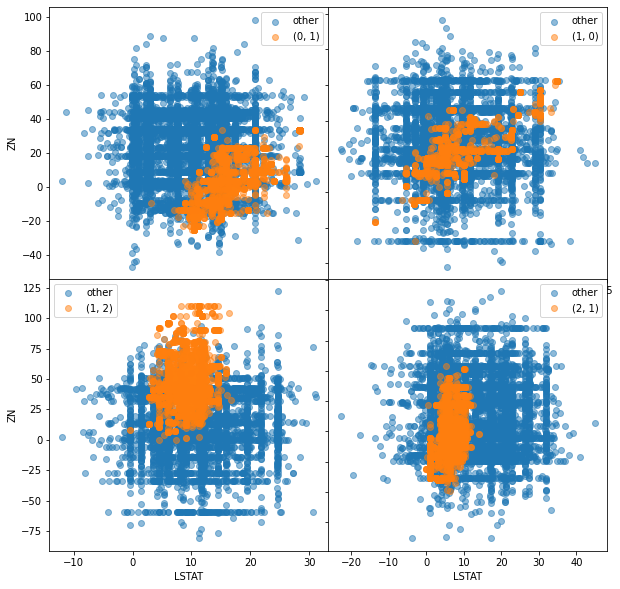

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    plot_diro2c_2d(explanation, 'LSTAT', 'ZN', ax=ax, class_names=['other', label])
    if label in ['(1, 0)', '(2, 1)']:
        ax.set_yticklabels([])
        ax.set_ylabel('')
plt.subplots_adjust(wspace=.0, hspace=0)
plt.savefig('figures/boston4-diro2c-scatter.png', bbox_inches='tight')

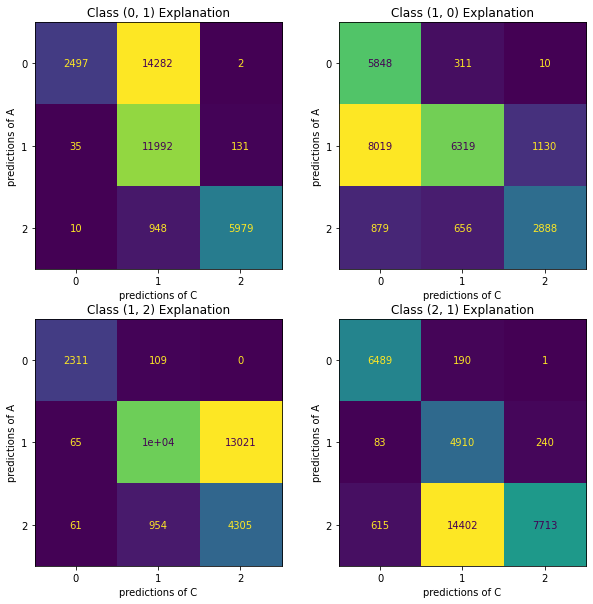

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    comparer.plot_confusion_matrix(get_generated_data(explanation)[0], ax=ax)
    ax.set_title(f'Class {label} Explanation')
plt.savefig('figures/boston4-diro2c-cm.pdf', bbox_inches='tight')

In [68]:
n_constraints = 0
for label, n_leafs in [
    ('(0, 1)', 4),
    ('(1, 0)', 4),
    ('(1, 2)', 3),
    ('(2, 1)', 5)
]:
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    trees = get_pruned_trees(explanation)
    _, feature_order = get_feature_importances(trees[-1])
    tree = [tree for tree in trees if tree.get_n_leaves() == n_leafs][0]
    constraints, rules, class_occurences, labels, rule_order =\
        extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions, latex=True)
    for rule in rules:
        print(f'\item if ${rule}$, then ${label}$')
    n_constraints += get_complexity(constraints)[1]
print(n_constraints)

\item if $\text{ZN} \leq 23 \land \text{LSTAT} > 8.62 \land \text{TAX} \leq 603$, then $(0, 1)$
\item if $\text{CRIM} \leq 7.6 \land \text{RM} \leq 6.10 \land \text{TAX} > 344$, then $(1, 0)$
\item if $\text{ZN} > 15 \land \text{LSTAT} \leq 14.48$, then $(1, 2)$
\item if $3.48 < \text{LSTAT} \leq 10.47 \land \text{ZN} \leq 23 \land \text{RM} > 6.83$, then $(2, 1)$
\item if $\text{LSTAT} \leq 10.47 \land \text{ZN} \leq 23 \land \text{RM} \leq 6.83$, then $(2, 1)$
15
